# Esercizio Classificazione

L'Organizzazione mondiale della sanità ha stimato che 12 milioni di decessi si verificano in tutto il mondo, ogni anno a causa di malattie cardiache. La metà dei decessi negli Stati Uniti e in altri paesi sviluppati è dovuta a malattie cardiovascolari. La prognosi precoce delle malattie cardiovascolari può aiutare a prendere decisioni sui cambiamenti dello stile di vita nei pazienti ad alto rischio e, a sua volta, ridurre le complicanze.

In questo esercizio si chiedere di utilizzare i decision tree (e magari i boosted decision trees) per individuare i fattori di rischio delle malattie cardiache più rilevanti e prevedere il rischio complessivo utilizzando la regressione logistica.

Il dataset con i dati che useremo si trova nel filw `data/framingham.csv`. 

Il dataset contiene i seguenti dati:

Demografici:
- male: maschio o femmina (nominale)
- age: età del paziente (continua - Sebbene le età registrate siano state troncate a numeri interi, il concetto di età è continuo)

Comportamentali:
- currentSmoker: se il paziente sia o meno un fumatore attuale (nominale)
- cigsPerDay: il numero di sigarette che la persona ha fumato in media in un giorno (può essere considerato continuo in quanto si può avere un numero qualsiasi di sigarette, anche mezza sigaretta)

Storia medica:
- BPMeds: se il paziente assumeva o meno un farmaco per la pressione arteriosa (nominale)
- prevalentStroke: se il paziente ha avuto o meno un ictus (nominale)
- prevalentHyp: se il paziente è iperteso (nominale)
- diabetes: se il paziente ha o meno il diabete (nominale)

Situazione medica attuale:
- totChol: livello di colesterolo totale (continuo)
- sysBP: pressione arteriosa sistolica (continua)
- diaBP: pressione arteriosa diastolica (continua)
- BMI: indice di massa corporea (continuo)
- heartRate: frequenza cardiaca (continua - Nella ricerca medica, variabili come la frequenza cardiaca, sebbene in realtà discrete, sono comunque considerate continue a causa del gran numero di possibili valori)
- glucose: livello di glucosio (continuo)

Variabile che si vuole predire (target desiderato):
- TenYearCHD: Rischio di malattia coronarica nei prossimi 10 anni CHD (binario: '1' significa sì, '0' significa no)

Si richiede di leggere il dataset, fare una parte di statistica descrittiva e quindi di provare a creare un albero decisionale sui dati in esso contenuti per descrivere quali variabili influiscono maggiormente sul consumo alcolico nei ragazzi.

L'albero può essere troncato ad una profondità di qualche livello e deve essere allegato e discusso con alcune considerazioni sul dataset.

Dopo la realizzazione dell'albero, viene richiesto di disegnarlo e caricare l'immagine nel notebook (è possibile utilizzare il sito internet visto a lezione (http://webgraphviz.com).
I risultati ottenuti nell'albero devono essere quindi brevemente commentati.

# Indice
* [Setting](#setting)
* [Lettura dataset](#lettura)
* [Esplorazione](#esplorazione)
    * [Caratteristiche principali](#)
    * [Verifica duplicati](#)
    * [Verifica missing values](#)
    * [Distribuzione variabili](#)
    * [Analisi correlazione](#)
* [Pre processing](#pre-proc)
    * [Gestione missing values](#)
    * [Creazione dummy variables](#)
    * [Verifica class imbalance](#)
* [Feature selection](#fs)
    * [Divisione train test](#)
    * [Gestione class imbalance](#)
    * [Decision Tree](#)
        * [Fit del modello](#)
        * [Previsioni sul test set](#)
        * [Performances](#)
        * [Feature importances](#)
        * [Salvataggio albero](#)
    * [Boosted Decision Tree V1 & V2](#)
        * [Fit del modello](#)
        * [Previsioni sul test set](#)
        * [Performances](#)
        * [Feature importances](#)
    * [SelectKBest](#)
        * [Fit del modello](#)
        * [Fetaure importances](#)
* [Previsione: Logisitic Regression](#lr)
    * [Selezione feature individuate](#)
    * [Divisione train test](#)
    * [Scaling](#)
    * [Gestione class imbalance](#)
    * [Fit del modello](#)
    * [Previsioni](#)
    * [Performance](#)

# Setting

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling as pp
import missingno as msno
from imblearn.under_sampling import NearMiss
from dtreeviz.trees import dtreeviz
import numpy as np
import shap
import graphviz
import xgboost as xgb
import itertools
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier  # implementa XGBoost
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
sns.set(rc={'figure.figsize':(10,7)})
RANDOM_STATE = 123
nr = NearMiss(version=3)
smote = SMOTE(random_state=RANDOM_STATE)
ros = RandomOverSampler(random_state=RANDOM_STATE)

In [298]:
def plot_confusion_matrix(y_test, y_pred):
    '''
    Viene plottata una matrice di confusione
    '''
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


def performances(y_test, y_pred):
    '''
    Vengono calcolate le principali metriche: accuracy, f1, precision, recall
    '''

    # check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
    acc = accuracy_score(y_test, y_pred)
    print(f"The accuracy score for LogReg is: {round(acc,3)*100}%")

    # f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
    f1 = f1_score(y_test, y_pred)
    print(f"The f1 score for LogReg is: {round(f1,3)*100}%")

    # Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
    precision = precision_score(y_test, y_pred)
    print(f"The precision score for LogReg is: {round(precision,3)*100}%")

    # recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
    recall = recall_score(y_test, y_pred)
    print(f"The recall score for LogReg is: {round(recall,3)*100}%")


def plot_roc(y_test, y_pred):
    '''
    Viene plottata la ROC curve
    '''
    fig, ax = plt.subplots()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f'Test AUC {roc_auc:.3f}')

    ax.plot(fpr, tpr, label="ROC curve")
    ax.plot([0, 1], [0, 1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver operating characteristic")
    ax.legend(loc="lower right")

    plt.show()

# Lettura dataset

In [299]:
df = pd.read_csv("data/framingham.csv")
df.head()

# si osservano 15 variabili indipendenti (fattori di rischio) e 1 variabile dipendente (TenYearCHD)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# Esplorazione

## Caratteristiche principali

In [300]:
df.shape

(4238, 16)

In [301]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [302]:
df.describe(include='all')

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [303]:
# pp.ProfileReport(df)

## Verifica duplicati

In [304]:
sum(df.duplicated())

# non ci sono duplicati

0

## Verifica missing values

In [305]:
df.isnull().sum()

# ci sono diversi valori mancanti

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [306]:
# percentuale della totalità dei valori mancanti sull'intero dataset

df.isnull().sum().sum()/len(df)

0.15219443133553562

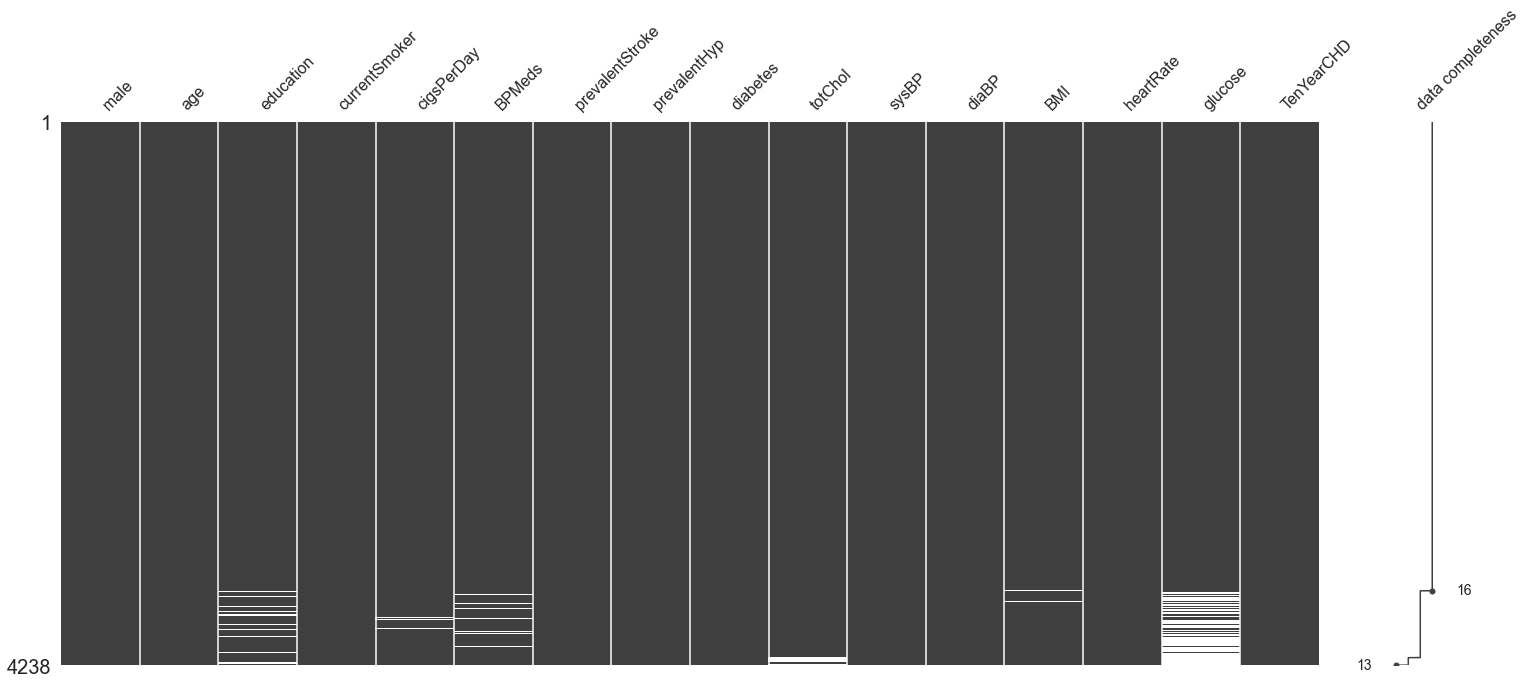

In [307]:
# per comprendere meglio la distribuzione dei valori mancanti

msno.matrix(df, labels=True, sort="descending");

,column_name,percent_missing
glucose,glucose,9.155262
education,education,2.477584
BPMeds,BPMeds,1.250590
totChol,totChol,1.179802
cigsPerDay,cigsPerDay,0.684285
BMI,BMI,0.448325
heartRate,heartRate,0.023596
male,male,0.000000
age,age,0.000000
currentSmoker,currentSmoker,0.000000


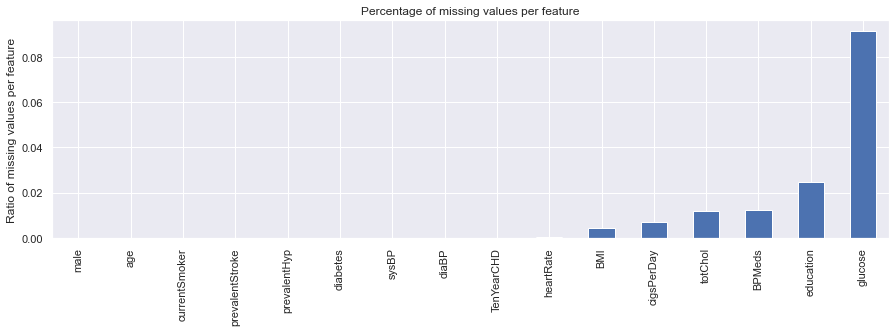

In [308]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")


percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

# la maggior parte dei valori mancanti sono relativi alla variabile glucose

In [309]:
# vengono analizzati nel dettaglio i valori mancanti

df[df.isna().any(axis=1)]

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
14,0,39,2.0,1,9.0,0.0,0,0,0,226.0,114.0,64.0,22.35,85.0,NaN,0
21,0,43,1.0,0,0.0,0.0,0,0,0,185.0,123.5,77.5,29.89,70.0,NaN,0
26,0,60,1.0,0,0.0,0.0,0,0,0,260.0,110.0,72.5,26.59,65.0,NaN,0
33,1,61,NaN,1,5.0,0.0,0,0,0,175.0,134.0,82.5,18.59,72.0,75.0,1
36,1,56,NaN,0,0.0,0.0,0,0,0,257.0,153.5,102.0,28.09,72.0,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,0,51,1.0,1,9.0,0.0,0,0,0,340.0,152.0,76.0,25.74,70.0,NaN,0
4229,0,51,3.0,1,20.0,0.0,0,1,0,251.0,140.0,80.0,25.60,75.0,NaN,0
4230,0,56,1.0,1,3.0,0.0,0,1,0,268.0,170.0,102.0,22.89,57.0,NaN,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0


## Distribuzione variabili

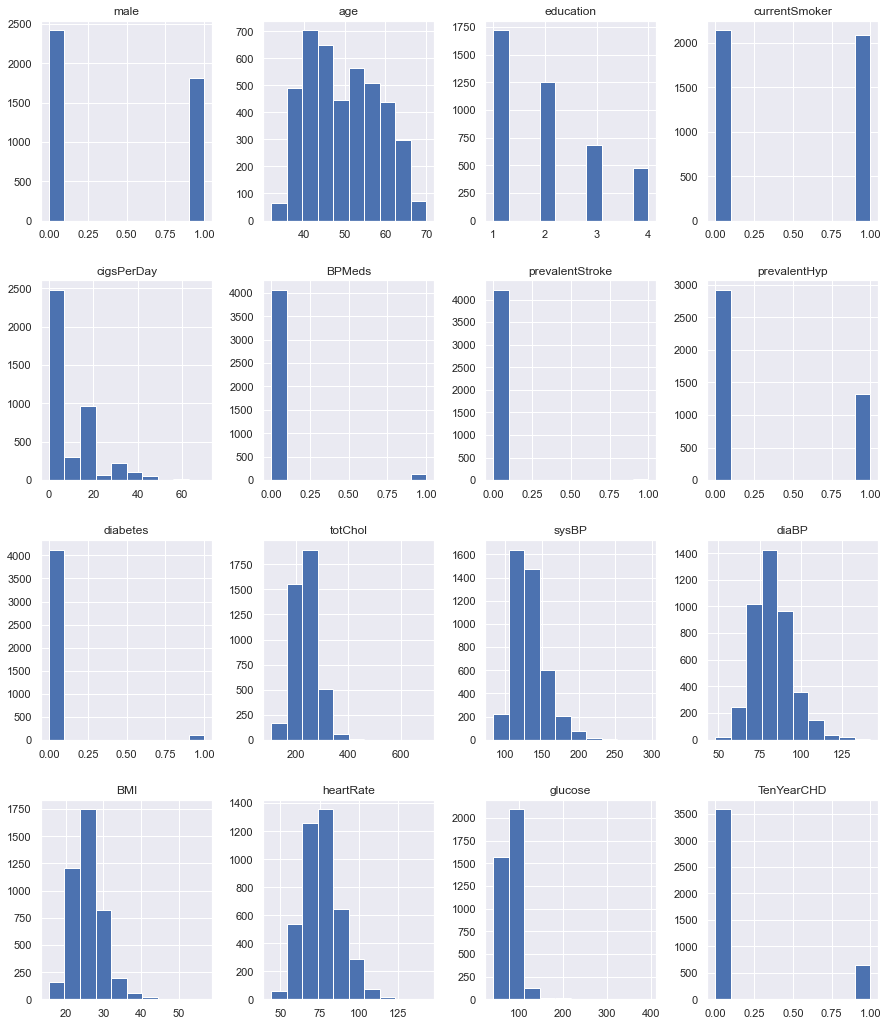

In [310]:
df.hist(figsize=(15,18))
plt.show()

# già da questi grafici si nota:

# male - una maggiore presenza di soggetti maschili

# age - la maggior parte dei soggetti ha un'eta di circa 40/50 anni

# education - in pochi hanno un livello di educazione elevato

# currentSmoker - ci sono tanti fumatori quanti non fumatori

# cigsPerDay - sono pochi i soggetti che fumano più i 20 sigarette

# BPMeds - la maggior parte dei paziente non assume farmaci per l'alta pressione

# prevalentStroke - solo pochi pazienti hanno avuto degli eposodi di ictus

# prevalentHyp - gran parte dei soggetti non registra prevalenza di ipertensione

# diabetes - solo una piccola percentuale ha il diabete

# totChol - la maggior parte dei pazienti ha come valore di colesterolo un valore compreso tra 200 e 300

# sysBP - la maggior parte dei pazienti ha come valore di pressione sanguigna sistolica un valore compreso tra 100 e 150

# diaBP - la maggior parte dei pazienti ha come valore di pressione sanguigna diastolica un valore compreso tra 75 e 100

# BMI - la maggior parte dei pazienti ha come valore di indice di massa corporea un valore compreso tra 20 e 30

# heartRate - la maggior parte dei pazienti ha come valore di frequenza cardiaca in bpm un valore compreso tra 60 e 90

# glucose - gran parte dei paziente ha un valore di glucosio inferiore a 100

# TenYearCHD - la maggior parte dei paziente presenta un rischio di contrarre uan malattia coronaica nei prossimi 10 anni

Si procede con l'esplorazione di ulteriori grafici

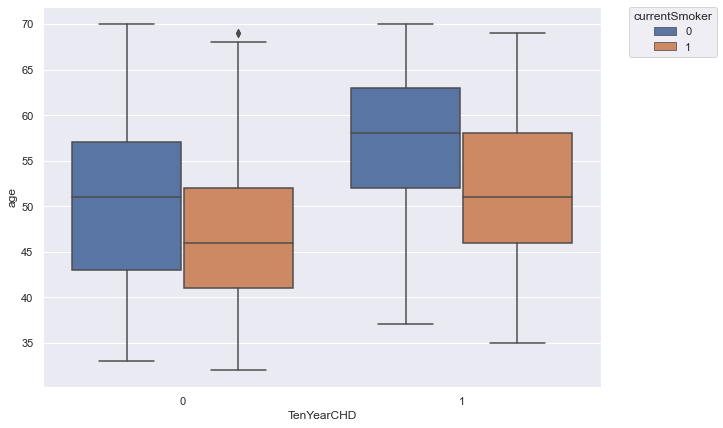

In [311]:
# relazione tra TenYearCHD, age e currentSmoker

sns.boxplot(x='TenYearCHD',y='age',hue='currentSmoker',data=df)
plt.legend(title='currentSmoker', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# emerge che i pazienti fumatori hanno un rischio più elevato ad unìetà inferiore rispetto ai pazienti non fumatori

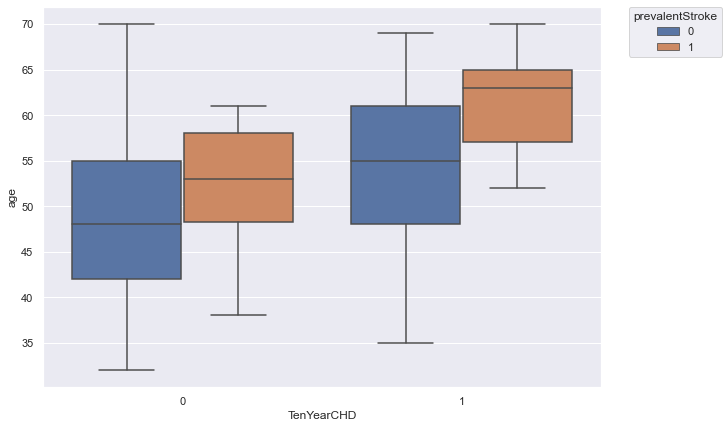

In [312]:
# relazione tra TenYearCHD, age e prevalentStroke

sns.boxplot(x='TenYearCHD',y='age',hue='prevalentStroke',data=df)
plt.legend(title='prevalentStroke', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# si può osservare che gli infarti sono più frequenti in soggetti più anziani

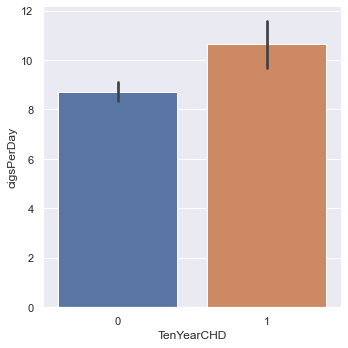

In [313]:
# relazione tra TenYearCHD e cigsPerDay

sns.catplot(x='TenYearCHD',y='cigsPerDay',kind='bar',data=df)

# i pazienti che hanno un rischio maggiore tendono a fumare più sigarette al giorno

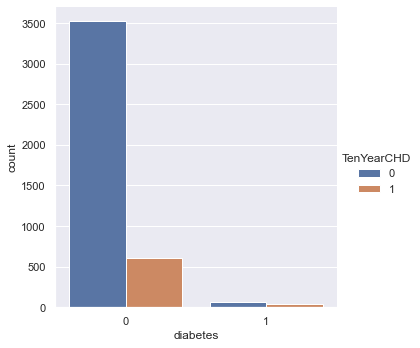

In [314]:
# relazione tra TenYearCHD e diabetes

sns.catplot(x='diabetes', hue='TenYearCHD',
                data=df, kind="count")

# tra i paziente che non sono a rischio la maggior parte non ha il diabete

In [315]:
# considerando la variabile target

df.TenYearCHD.value_counts()

# già da qui mi rendo conto che il dataset è sbilanciato

0    3594
1     644
Name: TenYearCHD, dtype: int64

## Analisi correlazione

In [316]:
# calcolo della correlazione

df.corr()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.028979,0.017352,0.197596,0.317930,-0.052506,-0.004546,0.005313,0.015708,-0.070322,-0.035989,0.057933,0.081672,-0.116620,0.006083,0.088428
age,-0.028979,1.000000,-0.165883,-0.213748,-0.192791,0.122995,0.057655,0.307194,0.101258,0.262131,0.394302,0.206104,0.135800,-0.012823,0.122256,0.225256
education,0.017352,-0.165883,1.000000,0.018532,0.008085,-0.010815,-0.035112,-0.081970,-0.038680,-0.023115,-0.129631,-0.062316,-0.137504,-0.054206,-0.035721,-0.054059
currentSmoker,0.197596,-0.213748,0.018532,1.000000,0.769690,-0.048938,-0.032988,-0.103260,-0.044295,-0.046562,-0.130230,-0.107746,-0.167650,0.062356,-0.056826,0.019456
cigsPerDay,0.317930,-0.192791,0.008085,0.769690,1.000000,-0.046134,-0.032707,-0.066146,-0.037067,-0.026320,-0.088780,-0.056632,-0.092856,0.075157,-0.058960,0.057884
BPMeds,-0.052506,0.122995,-0.010815,-0.048938,-0.046134,1.000000,0.117365,0.261187,0.052047,0.080558,0.254219,0.194227,0.100668,0.015233,0.051176,0.087489
prevalentStroke,-0.004546,0.057655,-0.035112,-0.032988,-0.032707,0.117365,1.000000,0.074830,0.006949,0.000067,0.057009,0.045190,0.025891,-0.017676,0.018431,0.061810
prevalentHyp,0.005313,0.307194,-0.081970,-0.103260,-0.066146,0.261187,0.074830,1.000000,0.077808,0.163993,0.696755,0.615751,0.301318,0.147261,0.086834,0.177603
diabetes,0.015708,0.101258,-0.038680,-0.044295,-0.037067,0.052047,0.006949,0.077808,1.000000,0.040278,0.111283,0.050329,0.087036,0.048994,0.617627,0.097317
totChol,-0.070322,0.262131,-0.023115,-0.046562,-0.026320,0.080558,0.000067,0.163993,0.040278,1.000000,0.208908,0.165182,0.115767,0.091125,0.046408,0.082184


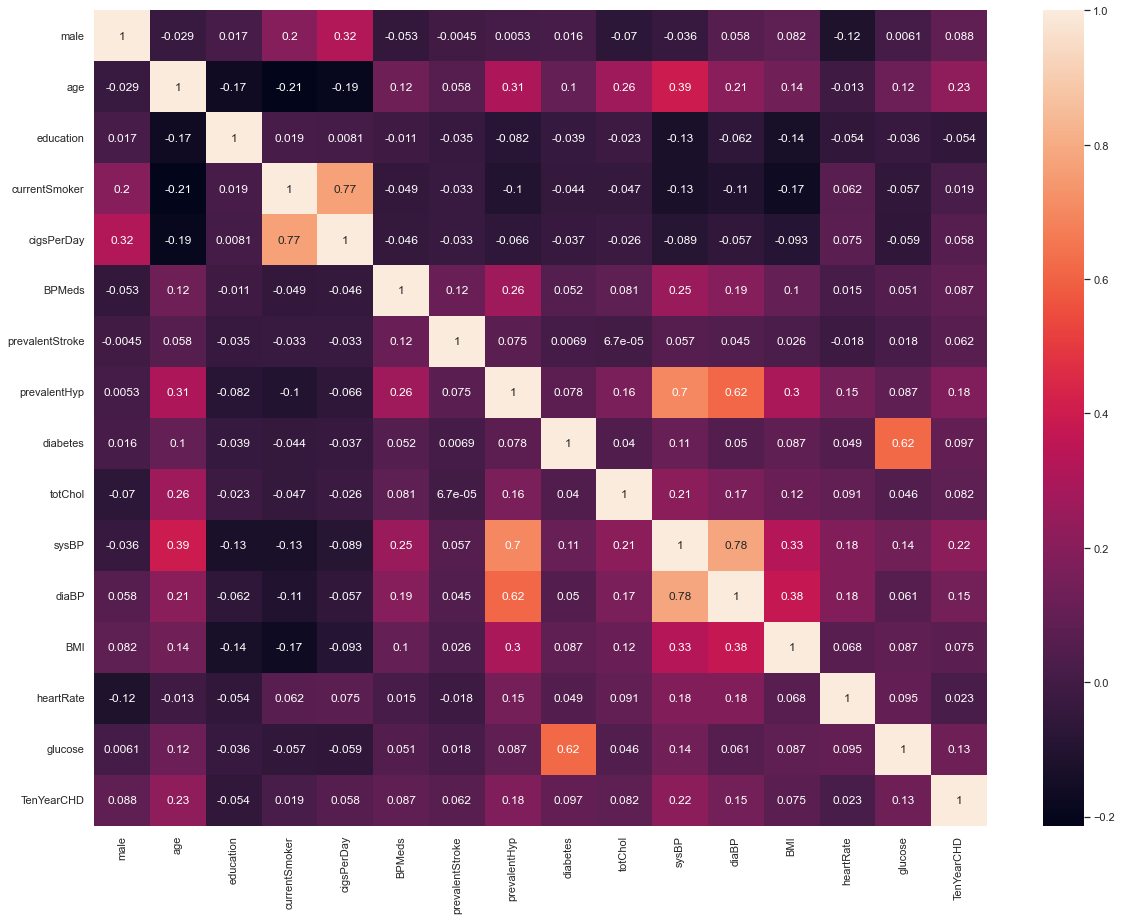

In [317]:
# visualizzazione della correlazione

f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

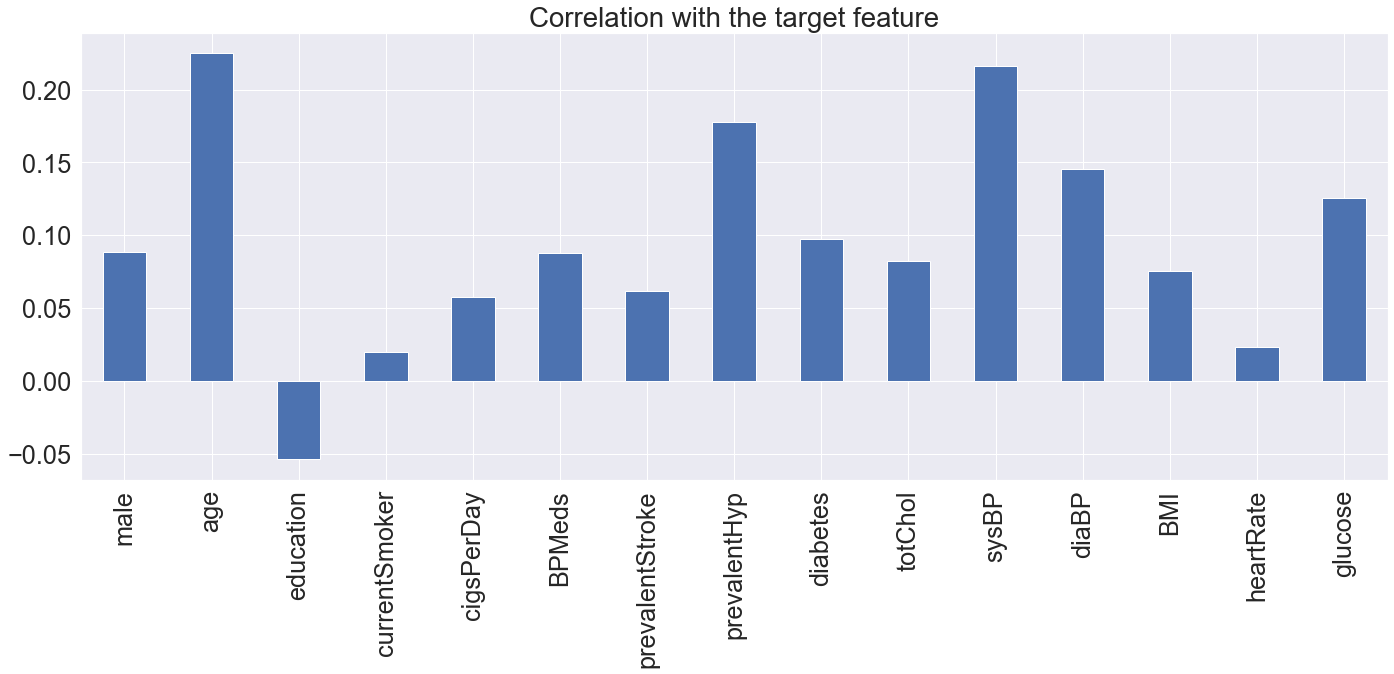

In [318]:
# si analizza più nel dettaglio la correlazione delle variabili indipendenti con la variabile target

sns.set_context('notebook',font_scale = 2.3)
df.drop('TenYearCHD', axis=1).corrwith(df.TenYearCHD).plot(kind='bar', grid=True, figsize=(20, 10),
                                                        title="Correlation with the target feature")
plt.tight_layout()

# Pre processing

## Gestione missing values

In [319]:
# Vengono eliminati tutti quei recordi presentanti valori mancanti. Dal momento in cui si tratta di record relativi a condizioni mediche adottare una metodologia di imputazione dei valori mancanti potrebbe essere rischioso

df_clean = df.dropna()
df_clean.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## Creazione dummy variables

In [320]:
# vengono create variabili dummies per alcune delle variabili categoriche

feature_names = ['male', 'education', 'currentSmoker', 'BPMeds',
                 'prevalentStroke', 'prevalentHyp', 'diabetes']

X = df_clean.drop(['TenYearCHD'], axis = 1)

# creazione variabili dummy: aumentato il numero di feature, 9 feature in più si hanno rispetto alla situazione inziale
X = pd.get_dummies(X, columns=feature_names)

y = df_clean.TenYearCHD

In [321]:
X.head()  # variabili indipendenti, potenziali fattori di rischio

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_0,male_1,...,currentSmoker_0,currentSmoker_1,BPMeds_0.0,BPMeds_1.0,prevalentStroke_0,prevalentStroke_1,prevalentHyp_0,prevalentHyp_1,diabetes_0,diabetes_1
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0,1,...,1,0,1,0,1,0,1,0,1,0
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0,1,0,...,1,0,1,0,1,0,1,0,1,0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0,0,1,...,0,1,1,0,1,0,1,0,1,0
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0,1,0,...,0,1,1,0,1,0,0,1,1,0
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0,1,0,...,0,1,1,0,1,0,1,0,1,0


In [322]:
y.head()  # variabile target, rischio o meno di malattia coronarica nei prossimi 10 anni

0    0
1    0
2    0
3    1
4    0
Name: TenYearCHD, dtype: int64

## Verifica class imbalance

Class 0: 3099
Class 1: 557
Proportion: 5.56 : 1


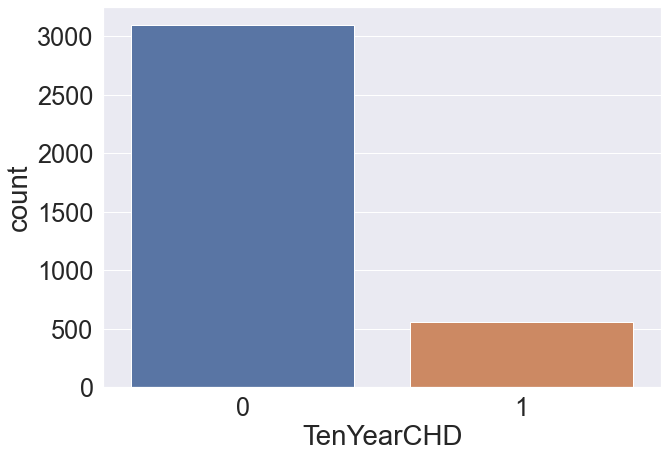

In [323]:
# considerando l'intero dataset

ax = sns.countplot(x=y)

target_count = df_clean.TenYearCHD.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# si è in presenza di un dataset sbilanciato, ovvero vi è la predominanza di una classe rispetto all'altra (in questo caso alla maggior parte dei pazienti non viene previsto il rischio di contrarre una malattia coronarica nei prossimi 10 anni)

# Fetaure selection
Si testano 3 differenti metodi per individuare le feature più rilevanti

## Divisione train test

In [324]:
# si esegue lo split in train test: trian 80 % - test 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_STATE)

print('X_train: ', X_train.size)
print('y_train: ', y_train.size)
print('X_test: ', X_test.size)
print('y_test: ', y_test.size)

X_train:  70176
y_train:  2924
X_test:  17568
y_test:  732


## Gestione class imbalance

0    2480
1     444
Name: TenYearCHD, dtype: int64

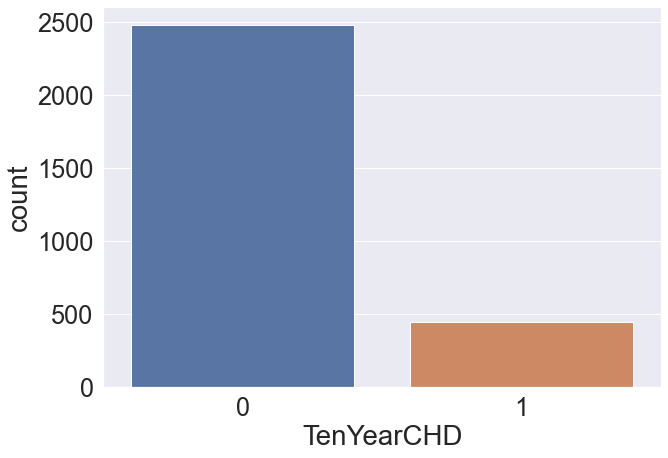

In [325]:
# si osserva la condizione di class imbalance (osservata precedentemente sull'intero datatset) sul train

ax = sns.countplot(x=y_train)
pd.DataFrame(y_train).TenYearCHD.value_counts()

Vengono testate due tecniche differenti per risolvere il problema della class imbalance. Entrambe vengono applicate sul train set. L'undersampling ha come aspettivo negativo il rischio di perdere informazioni importanti. Ad ogni modo, sia con undersampling che con oversampling si distorce la situazione reale di partenza.   

Considerata la numerosità limitata del dataset si opta per l'overesampling perchè applicando la tecnica dell'undersampling si ridurrebbe eccessivamente il dataset.

### Undersampling
Si perdono molte informazioni

In [326]:
# per risolvere il problema della class imbalance si procede tramite la tecnica di undersampling NearMiss. Tale metodo al posto di fare il resempling della classe minoritatia, utilizzando uan distanza fa si che la classe maggioritaria acqusisca una dimensionalità pari a quella della classe minoritaria. Alternativamente si poteva procedere selezionando in modo casuale delle osservazioni dalla classe maggioritaria e eliminandole fino ad ottenere una numeorsità pari a quella della classe minoritaria. L'undersampling permette dunque risolvere il problema delle classi sbilanciate, tutta via bisogna considerare che si sta perdendo una porzione di informazione.
# tale strategia viene applicata solamente sul train set

# https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145

# X_train, y_train = nr.fit_resample(X_train, y_train.ravel())
# print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
# ax = sns.countplot(x=y_train)

### Oversampling
Si creano nuove copie di record già esistenti in modo tale da risolvere il problema della class imbalance.

In [327]:
# tecnica 1
# X_train, y_train= smote.fit_resample(X_train, y_train)
# print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
# ax = sns.countplot(x=y_train)

[(0, 2480), (1, 2480)]


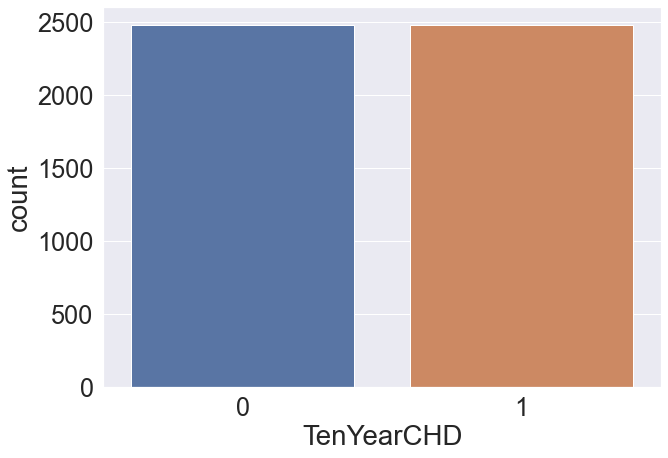

In [328]:
# tecnica 2
X_train, y_train = ros.fit_resample(X_train,y_train)
print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
ax = sns.countplot(x=y_train)

## Decision tree
Negli alberi decisionali le features più importanti si trovano vicino alla radice dell'albero.

In [329]:
# https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

# https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2

# https://www.youtube.com/watch?v=7v4Qdm5v9aA

### Grid Search CV

In [330]:
full_tree = DecisionTreeClassifier(random_state=123)  # l'albero viene troncato all'altezza max_depth (3)
full_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [331]:
max_depth = full_tree.get_depth()
max_depth

22

In [332]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ParameterGrid, GridSearchCV
max_depth_grid_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=123),
    scoring = make_scorer(recall_score),
    param_grid = ParameterGrid(
        {"max_depth": [[max_depth] for max_depth in range(1, max_depth+1)]}
    ),
)
max_depth_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x0000020D53F083D0>,
             scoring=make_scorer(recall_score))

In [333]:
max_depth_grid_search.best_params_

{'max_depth': 18}

In [334]:
dct = DecisionTreeClassifier(max_depth=18)  
dct.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=18)

### Fit del modello

In [335]:
dct = DecisionTreeClassifier(max_depth=4)  # l'albero viene troncato all'altezza max_depth 
dct.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [336]:
# performances sul train set

Y_pred_train = dct.predict(X_train)
performances(y_train, Y_pred_train)

The accuracy score for LogReg is: 68.7%
The f1 score for LogReg is: 70.19999999999999%
The precision score for LogReg is: 67.0%
The recall score for LogReg is: 73.7%


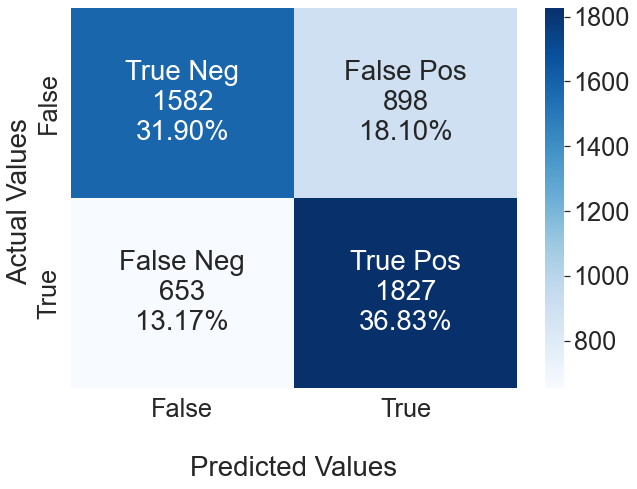

In [337]:
# confusion matrix sul train set

plot_confusion_matrix(y_train, Y_pred_train)

### Previsioni sul test set

In [338]:
prediction = dct.predict(X_test)
prediction

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

### Performances

In [339]:
performances(y_test, prediction)

# nel caso preso in esame è bene fare attenzione alla metrica recall dal momento in cui si preferisce avere dei falsi postivi (predirre che alcuni pazienti avranno malattie coronariche tra 10 anni quando in realtà non sarà cosi) piuttosto che avere dei falsi negativi (ovvero predirre che alcuni pazienti non avranno malattie quando invece è molto probabile che le avranno).

The accuracy score for LogReg is: 63.7%
The f1 score for LogReg is: 36.1%
The precision score for LogReg is: 24.8%
The recall score for LogReg is: 66.4%


In [340]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.91      0.63      0.75       619
           1       0.25      0.66      0.36       113

    accuracy                           0.64       732
   macro avg       0.58      0.65      0.55       732
weighted avg       0.81      0.64      0.69       732



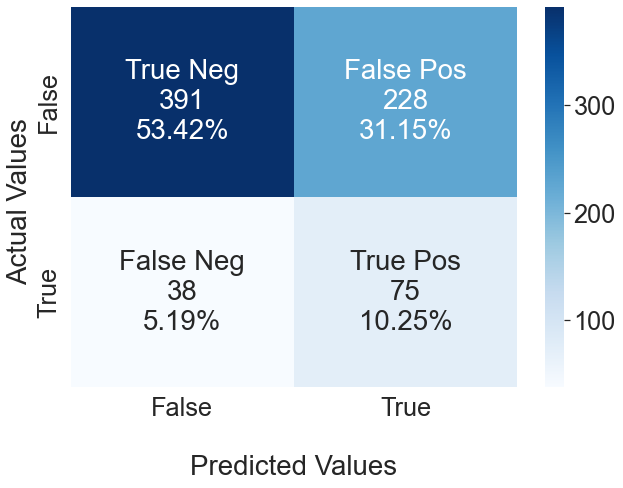

In [341]:
plot_confusion_matrix(y_test, prediction)

# come si può osservare il numero di falsi negativi è pari 43, mentre il numero di falsi positvi è pari a 253

In [343]:
# salvataggio tree in formato .dot

tree.export_graphviz(dct, out_file='data/tree.dot',
                                feature_names=X.columns,
                                class_names=['No Risk heart disease', 'Potential Risk heart disease'],
                                filled=True)

# tree.dot è possibile visualizzarlo tramite: http://webgraphviz.com/

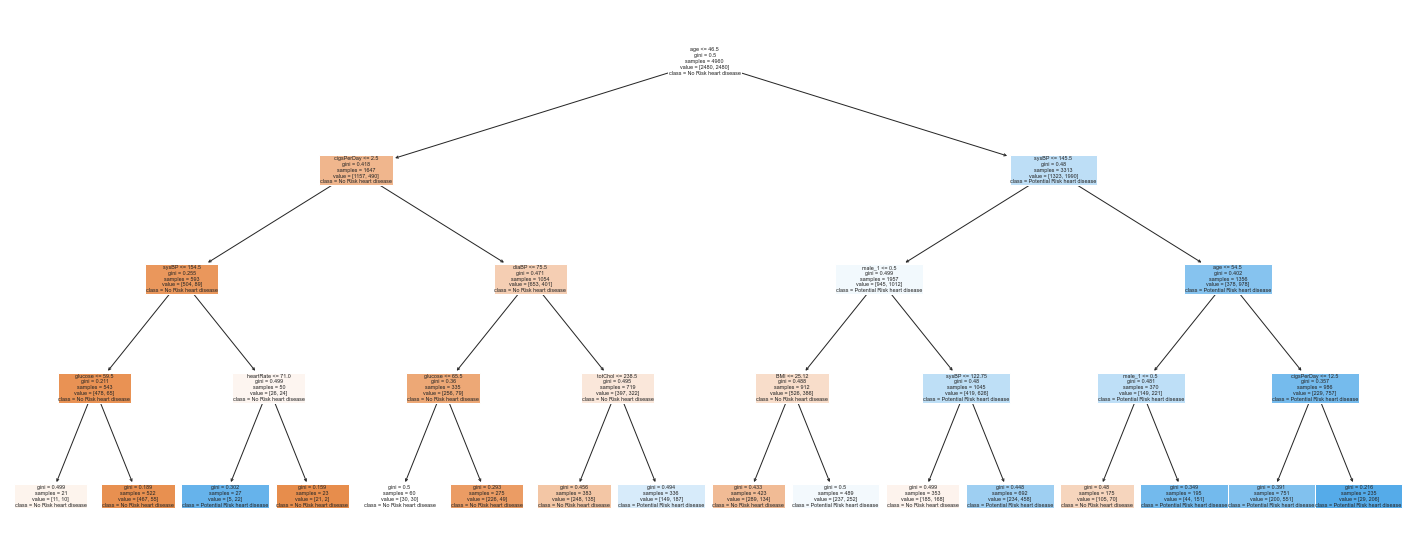

In [344]:
# Plot Tree with plot_tree

# plot dell'albero decisionale per individuare le feature più importanti

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dct,
                   feature_names=X.columns,
                   filled=True
                   #,max_depth=4
                   ,class_names=['No Risk heart disease', 'Potential Risk heart disease']
                   )
# si può aggiungere classe?
plt.show()

# se una feature dal nodo padre al nodo figlio causa una grande riduzione dell'impurità allora è una feature importante
# le feature che non compaiono nell'albero non risultano essere rilevanti
# nel primo nodo abbiamo 4960 record, 2480 apaprtenti alla classe 0 (no malattie cardiovascolati in futuro) e 2480 alla classe 1 (rischio malattie cardiovascolari in futuro)
# l'indice di gini è un indice che da un calcolo della probabilità che un elemento possa essere classificato erroneamente. L'obiettivo è avere un indice di gini basso, è pari a zero quando non ci sono errori.

# il nodo radice fa lo split sulla feature age. Si hanno inzialmente 4960 record divisi equamente nelle due classi Risk heart disease e Potential Risk heart disease
# 

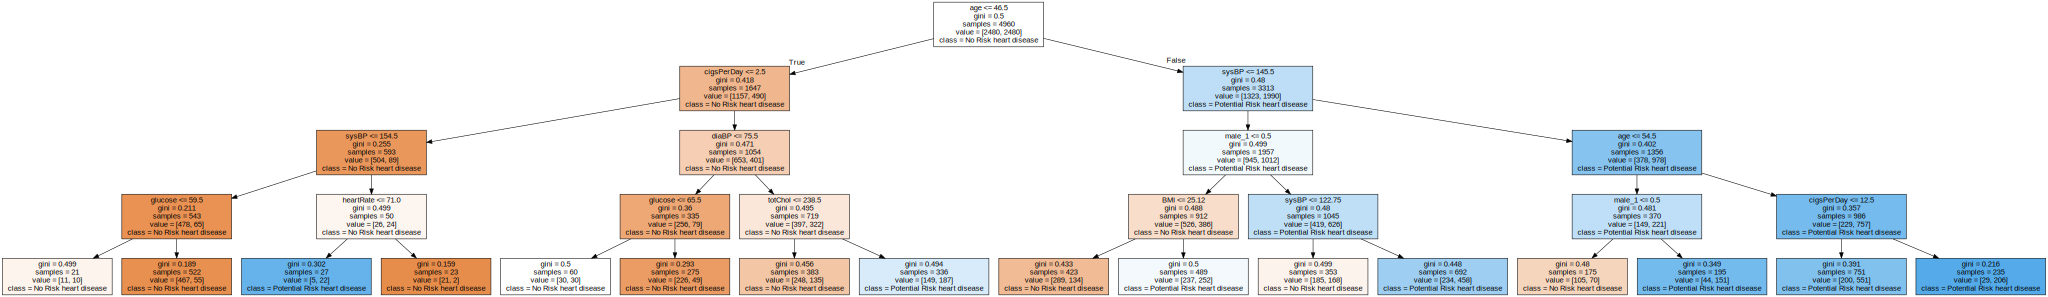

In [345]:
# metodo alternativo di visualizzazione: Visualize Decision Tree with graphviz

dot_data = tree.export_graphviz(dct, out_file=None,
                                feature_names=X.columns,
                                class_names=['No Risk heart disease', 'Potential Risk heart disease'],
                                filled=True)


graph = graphviz.Source(dot_data, format="png")
graph

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


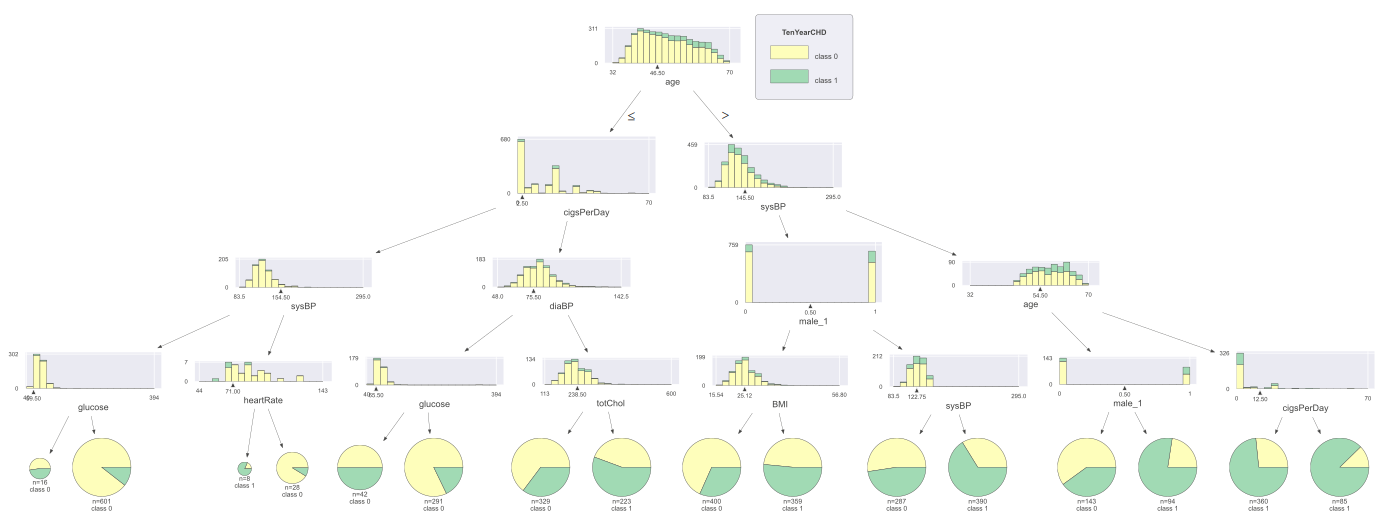

In [274]:
# metodo alternativo di visualizzazione: Plot Decision Tree with dtreeviz Package

viz = dtreeviz(dct, X, y,
               target_name='TenYearCHD',
               feature_names=X.columns)
viz

### Feature importances

In [275]:
# calcolo delle feature importances

for importance, name in sorted(zip(dct.feature_importances_, X_train.columns),reverse=True):
    print (name, importance)

age 0.4370503396721734
sysBP 0.19019092207153349
male_1 0.11225698202340657
cigsPerDay 0.09548230805749738
diaBP 0.04122218984700338
BMI 0.03587864231520075
glucose 0.03160814105223309
totChol 0.02990792185927596
heartRate 0.02640255310167598
prevalentStroke_1 0.0
prevalentStroke_0 0.0
prevalentHyp_1 0.0
prevalentHyp_0 0.0
male_0 0.0
education_4.0 0.0
education_3.0 0.0
education_2.0 0.0
education_1.0 0.0
diabetes_1 0.0
diabetes_0 0.0
currentSmoker_1 0.0
currentSmoker_0 0.0
BPMeds_1.0 0.0
BPMeds_0.0 0.0


Text(0, 0.5, 'Feature Importance')

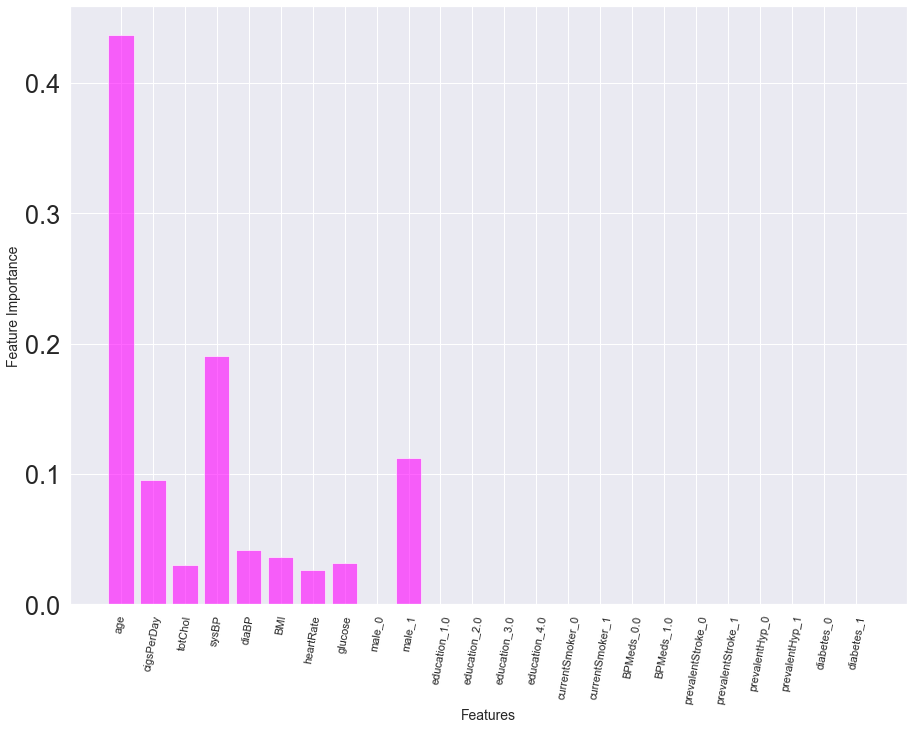

In [276]:
# metodo grafico alterantivo per studiare le feature importances

col_names_list_new = list(X.columns.values)
n_features = len(col_names_list_new)

fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), dct.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), col_names_list_new, rotation=80, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)

In [47]:
# in definitiva, secondo l'albero di decisione le features più importanti risultano essere:

# con undersampling
# - age
# - male_0
# - education_1.0
# - heartRate
# - totChol
# - diaBP
# - glucose

# con oversampling
# age
# cigsPerDay
# sysBP
# diaBP
# male_1

# con depth 4
# age
# cigsPerDay
# totChol
# sysBP
# diaBP
# BMI
# heartRate
# glucose
# male_1

### Salvataggio albero

In [48]:
# disegnare l'albero e salvare

# http://webgraphviz.com/
# digraph G {
#   "age" -> "hearRate" [ label = "age <= 44.5" ];
#   "age" -> "male_0" [ label = "age > 44.5" ];
#
#   "hearRate" -> "glucose" [ label = "hearRate <= 84.5" ];
#   "hearRate" -> "diaBP" [ label = "hearRate > 84.5" ];
#
#   "male_0" -> "totChol" [ label = "male_0 = 0" ];
#   "male_0" -> "education_1.0" [ label = "male_0 = 1" ];
#
#    "glucose" -> "potenziale rischio malattia cardiaca" [ label = "glucose <= 89.0" ];
#    "glucose" -> "potenziale rischio malattia cardiaca " [ label = "glucose > 89.0" ];
#
#    "diaBP" -> "no rischio malattia cardiaca" [ label = "diaBP <= 63.25" ];
#    "diaBP" -> "potenziale rischio malattia cardiaca. " [ label = "diaBP > 63.25" ];
#
#    "totChol" -> "potenziale rischio malattia cardiaca.  " [ label = "totChol <= 190.5" ];
#    "totChol" -> "no rischio malattia cardiaca " [ label = "totChol > 190.5" ];
#
#    "education_1.0" -> "potenziale rischio malattia cardiaca.   " [ label = "education_1.0 = 0" ];
#    "education_1.0" -> "no rischio malattia cardiaca  " [ label = "education_1.0 = 1" ];
#
# }


# With the following sintax we will create a .dot file with the code for visualizing the tree
# tree.export_graphviz(dct, out_file='out/tree.dot', feature_names=x.columns)

## Boosted Decision Tree V1

### Fit del modello

In [49]:
xgbtrain = xgb.DMatrix(data=X_train,
                       label=y_train)

xgbtest = xgb.DMatrix(data=X_test,
                       label=y_test)

param = {}

# Booster parameters
param['eta']              = 0.0001 # learning rate
param['max_depth']        = 5  # maximum depth of a tree
param['subsample']        = 0.5 # fraction of events to train tree on
param['colsample_bytree'] = 0.5 # fraction of features to train tree on
# sono stati fatti diversi tentativi per cercare di contrastare l'overfitting

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 20  # number of trees to make

booster = xgb.train(param, xgbtrain, num_boost_round=num_trees)
predictions = booster.predict(xgbtrain)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [50]:
d = pd.DataFrame()
d['Risk heart disease'] = y_train
d['prediction Risk heart disease'] = np.around(booster.predict(xgbtrain)).astype('int64')
d[['prediction Risk heart disease', 'Risk heart disease']]

,prediction Risk heart disease,Risk heart disease
0,0,1
1,1,0
2,0,0
3,0,0
4,1,0
...,...,...
4955,0,1
4956,0,1
4957,1,1
4958,1,1


In [51]:
right = d.loc[d['prediction Risk heart disease'] == d['Risk heart disease']]
wrong = d.loc[d['prediction Risk heart disease'] != d['Risk heart disease']]

true_positive = right.loc[right['prediction Risk heart disease'] == 1]
false_positive = wrong.loc[wrong['prediction Risk heart disease'] == 1]
false_negative = wrong.loc[wrong['prediction Risk heart disease'] == 0]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 4960 elements in our recordset.
We classified correctly 3721 events.
We classified wrongly 1239 events.
We had 601 false positive and 638 false negative.

Our precision has been 0.75.
Our recall has been 0.74.


### Previsioni sul test set

In [52]:
xgbtest = xgb.DMatrix(data=X_test,
                       label=y_test)

d = pd.DataFrame()
d['Risk heart disease'] = y_test
d['prediction Risk heart disease'] = np.around(booster.predict(xgbtest)).astype('int64')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Performances

In [53]:
right = d.loc[d['prediction Risk heart disease'] == d['Risk heart disease']]
wrong = d.loc[d['prediction Risk heart disease'] != d['Risk heart disease']]

true_positive = right.loc[right['prediction Risk heart disease'] == 1]
false_positive = wrong.loc[wrong['prediction Risk heart disease'] == 1]
false_negative = wrong.loc[wrong['prediction Risk heart disease'] != 1]

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))

We had 732 elements in our recordset.
We classified correctly 516 events.
We classified wrongly 216 events.
We had 165 false positive and 51 false negative.

Our precision has been 0.27.
Our recall has been 0.55.


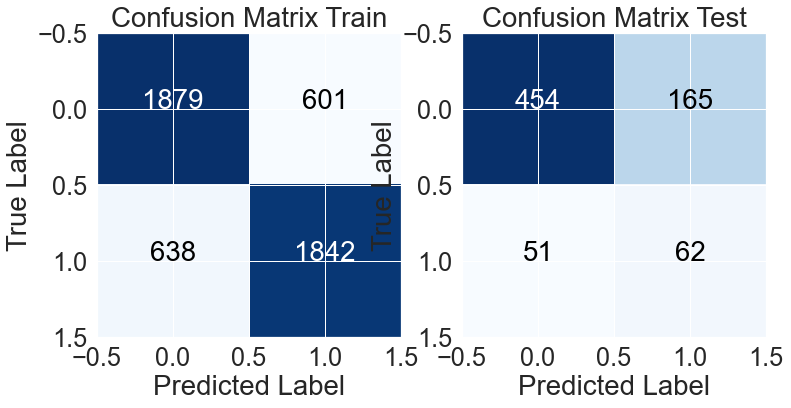

In [54]:
y_train_hat = np.around(booster.predict(xgbtrain)).astype('int64')
y_test_hat = np.around(booster.predict(xgbtest)).astype('int64')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cf = confusion_matrix(y_train, y_train_hat)
ax1.imshow(cf, cmap=plt.cm.Blues)
ax1.set_title("Confusion Matrix Train")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax1.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

cf = confusion_matrix(y_test, y_test_hat)
ax2.imshow(cf, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix Test")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    thresh = cf.max() / 2.0    
    ax2.text(j, i,
             cf[i, j], horizontalalignment="center",
             color="white" if cf[i, j] > thresh else "black")

plt.show()

Train AUC 0.837
Test AUC 0.679


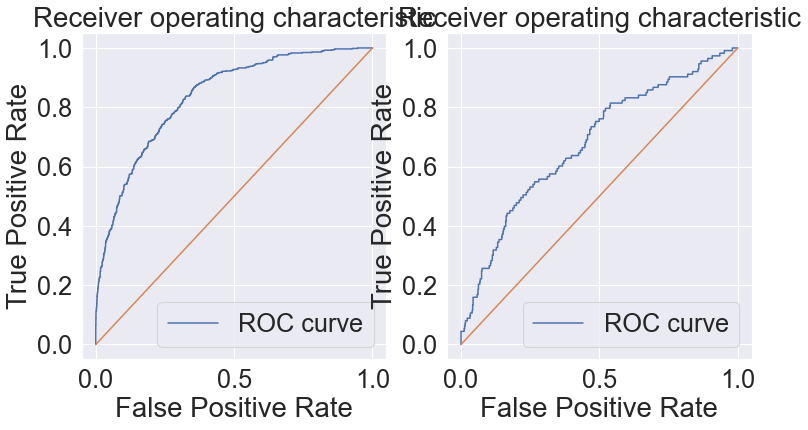

In [55]:
y_test_proba = booster.predict(xgbtest)
y_train_proba = booster.predict(xgbtrain)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
fpr, tpr, _ = roc_curve(y_train, y_train_proba)
roc_auc = auc(fpr, tpr)
print(f'Train AUC {roc_auc:.3f}')

ax1.plot(fpr, tpr, label="ROC curve")
ax1.plot([0, 1], [0, 1])
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver operating characteristic")
ax1.legend(loc="lower right")
    
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
print(f'Test AUC {roc_auc:.3f}')

ax2.plot(fpr, tpr, label="ROC curve")
ax2.plot([0, 1], [0, 1])
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("Receiver operating characteristic")
ax2.legend(loc="lower right")

plt.show()

### Feature importances

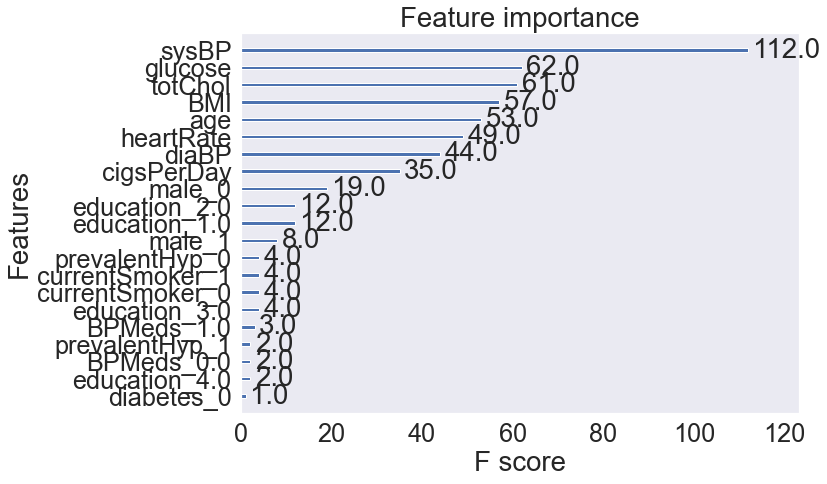

In [56]:
xgb.plot_importance(booster, grid=False)
plt.show()

In [57]:
# in definitiva, secondo il Boosted Decsion Tree V1 le features più importanti risultano essere:

# con undesampling
# - glucose
# - BMI
# - totChol
# - sysBP
# - heartRate
# - diaBP

# con oversampling
# - sysBP
# - glucose
# - totChol
# - BMI
# - age
# - heartRate
# - diaBP

## Boosted Decision Tree V2

### Fit del modello

In [58]:
# XGBoost ('eXtreme Gradient Boosting') and sklearn's GradientBoost are fundamentally the same as they are both gradient boosting implementations.
# However, there are very significant differences under the hood in a practical sense. XGBoost is a lot faster 
# than sklearn's. XGBoost is quite memory-efficient and can be parallelized (I think sklearn's cannot do so by default, 
# I don't know exactly about sklearn's memory-efficiency but I am pretty confident it is below XGBoost's).

m2 = 'Gradient Boosting Classifier'
gvc =  GradientBoostingClassifier()
gvc.fit(X_train,y_train)

GradientBoostingClassifier()

In [59]:
# performances sul train set

Y_pred_train = gvc.predict(X_train)
performances(y_train, Y_pred_train)

The accuracy score for LogReg is: 78.9%
The f1 score for LogReg is: 79.3%
The precision score for LogReg is: 77.7%
The recall score for LogReg is: 80.9%


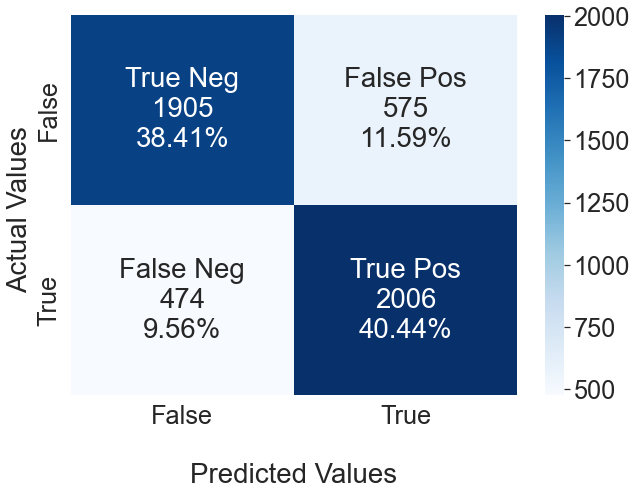

In [60]:
# confusion matrix sul train set

plot_confusion_matrix(y_train, Y_pred_train)

### Previsioni sul test set

In [61]:
gvc_predicted = gvc.predict(X_test)

### Performances

In [62]:
performances(y_test, gvc_predicted)

The accuracy score for LogReg is: 67.9%
The f1 score for LogReg is: 32.7%
The precision score for LogReg is: 24.2%
The recall score for LogReg is: 50.4%


In [63]:
print(classification_report(y_test, gvc_predicted))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       619
           1       0.24      0.50      0.33       113

    accuracy                           0.68       732
   macro avg       0.56      0.61      0.56       732
weighted avg       0.79      0.68      0.72       732



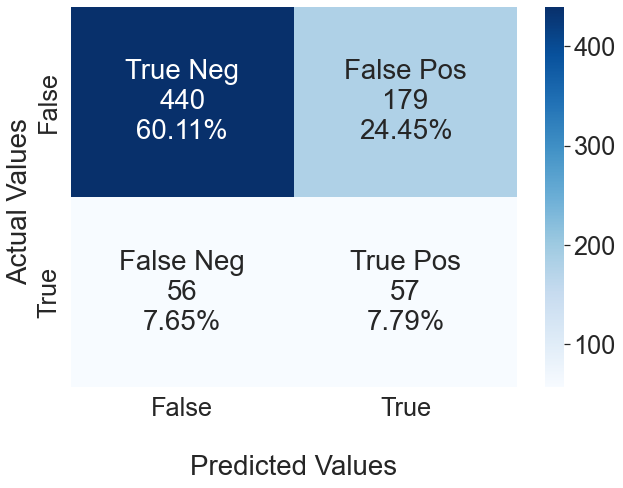

In [64]:
plot_confusion_matrix(y_test, gvc_predicted)

### Feature importances

In [65]:
# calcolo delle feature importances

for importance, name in sorted(zip(gvc.feature_importances_, X_train.columns),reverse=True):
    print (name, importance)

age 0.30022214682071635
sysBP 0.150890209466016
totChol 0.08726936018826816
cigsPerDay 0.08604053271371663
BMI 0.07743279116559622
glucose 0.076689438204431
heartRate 0.07096566661178254
diaBP 0.07083683661715323
male_1 0.025947134258613544
male_0 0.013859938874464977
education_1.0 0.012837581121892962
prevalentHyp_1 0.00453776682667816
education_2.0 0.0042689310707228
BPMeds_0.0 0.0035156624121930784
currentSmoker_1 0.0032039197628393385
education_3.0 0.0024172528850015472
education_4.0 0.0022850170321037097
currentSmoker_0 0.0017167294321542039
BPMeds_1.0 0.0014826260456630763
prevalentStroke_0 0.001479260003928875
prevalentHyp_0 0.0011435702271520994
diabetes_0 0.00048422010994858354
prevalentStroke_1 0.00047340814896295593
diabetes_1 0.0


Text(0, 0.5, 'Feature Importance')

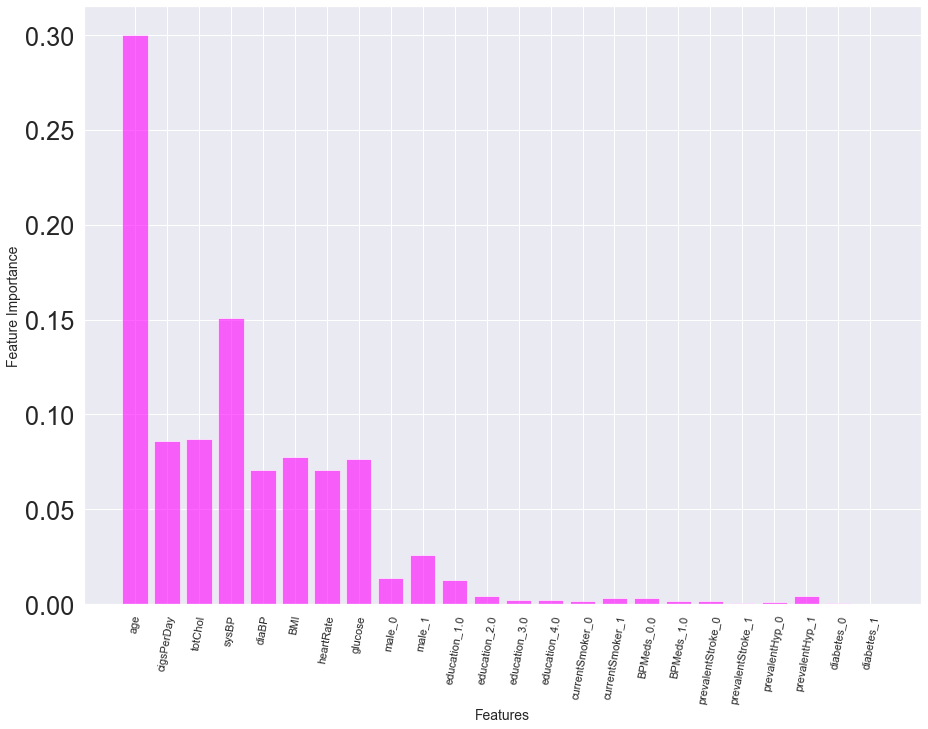

In [66]:
# metodo grafico alterantivo per studiare le feature importances

col_names_list_new = list(X.columns.values)
n_features = len(col_names_list_new)

fig = plt.figure(figsize=(15, 11))
fig.tight_layout()
plt.bar(range(n_features), gvc.feature_importances_, color="magenta", align="center", alpha=0.6)
plt.xticks(np.arange(n_features), col_names_list_new, rotation=80, fontsize=11)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Feature Importance", fontsize=14)

In [67]:
# in definitiva, secondo il Boosted Decsion Tree V2 le features più importanti risultano essere:

# con undersampling
# - BMI
# - sysBP
# - totChol
# - glucose
# - age
# - diaBP
# - heartRate

# con oversampling
# - age
# - cigsPerDay
# - totChol
# - sysBP
# - diaBP
# - BMI
# - heartRate
# - glucose

# le feature seleezionate sono simili a quelle individuate dal decision tree

## SelectKBest

### Fit del modello

In [68]:
best=SelectKBest(score_func=chi2, k=10)
fit=best.fit(X_train,y_train)

### Feature importances

In [69]:
data_scores=pd.DataFrame(fit.scores_)
data_columns=pd.DataFrame(X.columns)

#Join the two dataframes
scores=pd.concat([data_columns,data_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))

           Feature        Score
3            sysBP  1702.629750
7          glucose   892.290236
0              age   754.605168
1       cigsPerDay   703.696813
2          totChol   577.590728
4            diaBP   403.622021
21  prevalentHyp_1   154.781136
20  prevalentHyp_0    97.673463
5              BMI    52.717810
23      diabetes_1    48.000000
10   education_1.0    46.452504


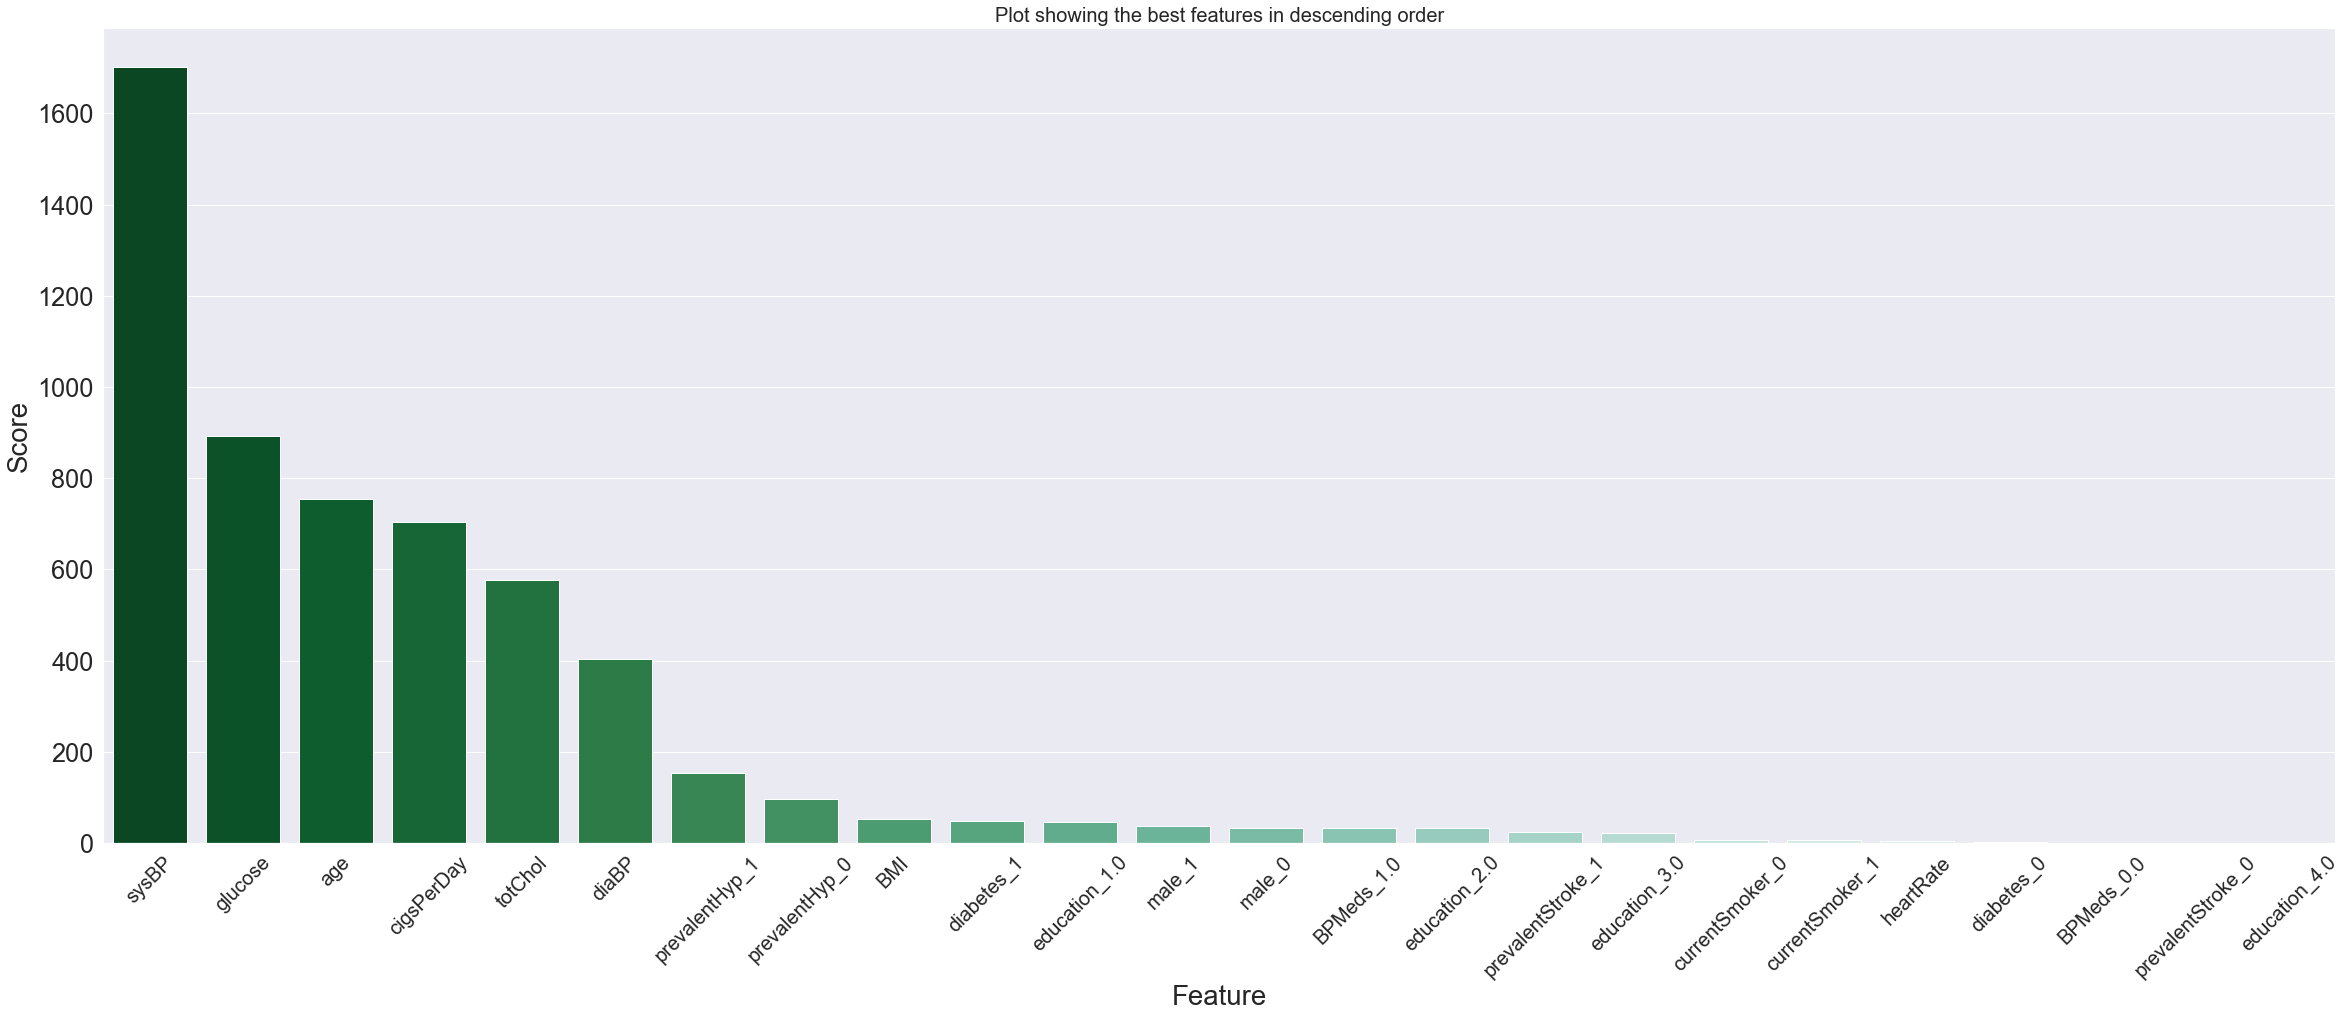

In [70]:
# visualizzazione grafica

scores=scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(40,15), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("Plot showing the best features in descending order", size=20)
plt.xticks(rotation=45, fontsize=20)
plt.show()

In [71]:
# in definitiva, secondo il SelectBest le features più importanti risultano essere:

# con undersampling:
# - age
# - heartRate
# - education_2.0
# - male_0
# - education_1.0
# - cigsPerDay
# - prevalentStroke_1

# con oversampling:
# - sysBP
# - glcuose
# - age
# - cigsPerDay
# - totChol
# - diaBP

# Previsione: Logistic Regression

## Selezione feature individuate

In [277]:
# si decidere di proseguire con le feature selezionate dal decision tree per cui si registravano le migliori performance

# feature da considerare
# feature_names = ['age', 'cigsPerDay', 'sysBP', 'diaBP', 'male_1']

feature_names = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male_1']  # con depth 4

# si crea un nuovo df con le feature selezionate
X = X[feature_names]
X.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_1
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0,1
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0,1
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0,0
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Divisione train test

In [278]:
# vengono creati nuovamente train e test con le feature selezionate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
X_train.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_1
2517,60,0.0,280.0,114.0,82.0,23.96,70.0,84.0,1
4134,46,20.0,247.0,134.0,96.0,32.47,80.0,72.0,1
3165,44,30.0,363.0,140.0,87.0,26.44,95.0,79.0,1
4137,42,0.0,238.0,118.0,80.0,33.19,75.0,76.0,0
3443,61,0.0,194.0,148.0,89.0,23.48,100.0,101.0,0


## Scaling

In [279]:
# viene effettuato lo scaling, necessario per il modello logistic regression, su X_train e X_test, considerando le variabili numeriche

# columns_to_scale = ['age', 'totChol', 'diaBP', 'heartRate', 'glucose']

# columns_to_scale = ['age', 'cigsPerDay', 'sysBP', 'diaBP']

columns_to_scale = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']  # con depth 4

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])
X_train.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_1
2517,1.231035,-0.763615,0.988557,-0.833379,-0.077029,-0.446882,-0.484044,0.098950,1
4134,-0.405548,0.916643,0.227737,0.075875,1.086752,1.674904,0.346752,-0.405475,1
3165,-0.639345,1.756772,2.902136,0.348651,0.338607,0.171453,1.592946,-0.111227,1
4137,-0.873143,-0.763615,0.020240,-0.651528,-0.243284,1.854420,-0.068646,-0.237334,0
3443,1.347934,-0.763615,-0.994187,0.712352,0.504861,-0.566560,2.008344,0.813553,0


## Gestione class imbalance

0    2480
1     444
Name: TenYearCHD, dtype: int64

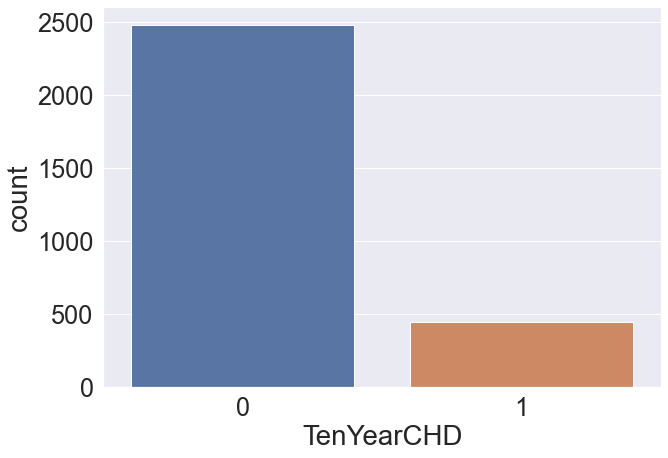

In [280]:
# verifica class imbalance

ax = sns.countplot(x=y_train)
pd.DataFrame(y_train).TenYearCHD.value_counts()

### Undersampling

In [281]:
# correzione class imbalance
# X_train, y_train = nr.fit_resample(X_train, y_train.ravel())
# print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
# ax = sns.countplot(x=y_train)

### Oversampling

In [282]:
# tecnica 1
# X_train, y_train= smote.fit_resample(X_train, y_train)
# print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
# ax = sns.countplot(x=y_train)

[(0, 2480), (1, 2480)]


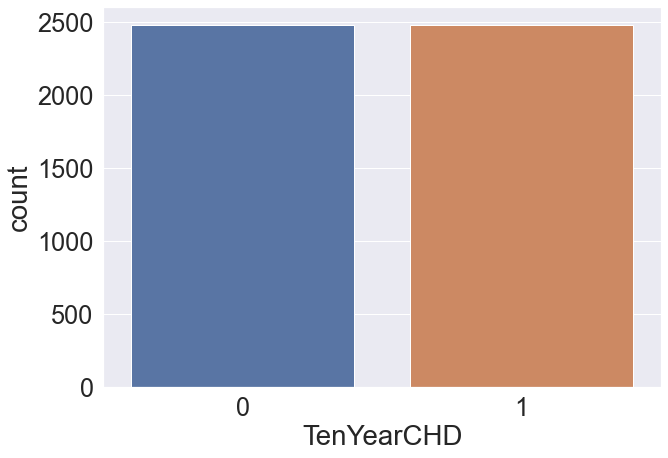

In [283]:
# tecnica 2
X_train, y_train = ros.fit_resample(X_train,y_train)
print(sorted(Counter(y_train).items()))

# si verifica nuovamente la class imbalance ed effettivamente la situazione pare essere migliorata
ax = sns.countplot(x=y_train)

## Fit del modello

In [284]:
# con grid search

# parameter_grid_logistic_regression = {
#     'max_iter': [20, 50, 100, 200, 500, 1000],                      # Number of iterations
#     'solver': ['newton-cg', 'lbfgs', 'liblinear'],                  # Algorithm to use for optimization
#     'class_weight': ['balanced']                                    # Troubleshoot unbalanced data sampling
# }

# logistic_Model_grid = GridSearchCV(estimator=LogisticRegression(random_state=123), 
#                                    param_grid=parameter_grid_logistic_regression, 
#                                    verbose=1, 
#                                    cv=100, 
#                                    n_jobs=-1)

# mod = logistic_Model_grid.fit(X_train, y_train)

In [285]:
mod = LogisticRegression()
mod.fit(X_train, y_train)

LogisticRegression()

In [286]:
# performances sul train set

Y_pred_train = mod.predict(X_train)
Y_proba_train = mod.predict_proba(X_train)
performances(y_train, Y_pred_train)

The accuracy score for LogReg is: 67.80000000000001%
The f1 score for LogReg is: 68.2%
The precision score for LogReg is: 67.4%
The recall score for LogReg is: 69.0%


Test AUC 0.678


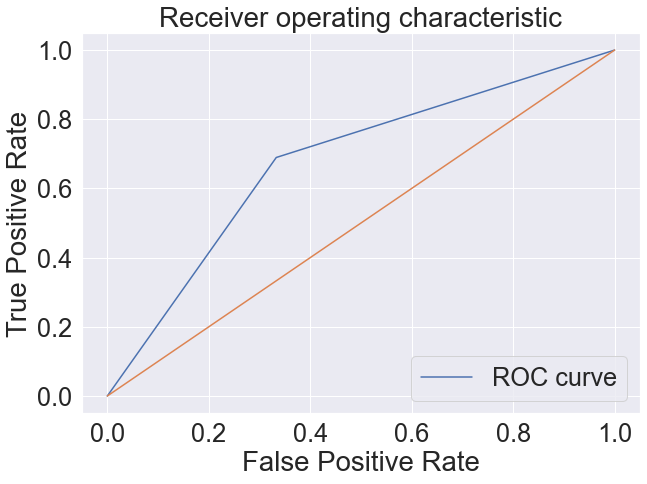

In [287]:
# ROC curve sul train set

plot_roc(y_train, Y_pred_train)

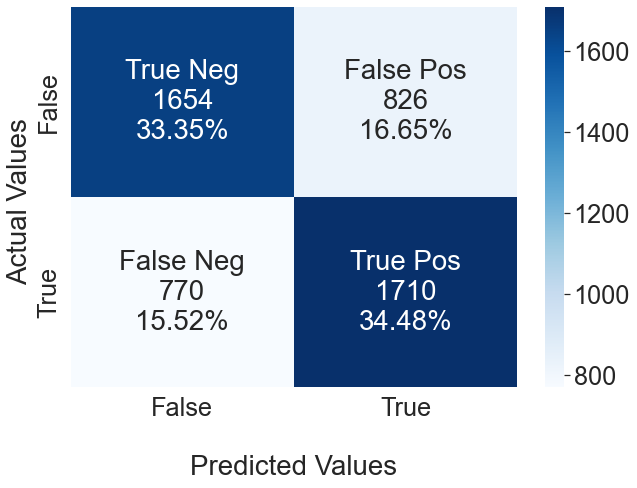

In [288]:
# confusion matrix sul train set

plot_confusion_matrix(y_train, Y_pred_train)

## Previsioni

In [289]:
pred = mod.predict(X_test)
pred_proba = mod.predict_proba(X_train)

## Performance

In [290]:
performances(y_test, pred)

The accuracy score for LogReg is: 66.8%
The f1 score for LogReg is: 36.199999999999996%
The precision score for LogReg is: 25.7%
The recall score for LogReg is: 61.1%


In [291]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78       619
           1       0.26      0.61      0.36       113

    accuracy                           0.67       732
   macro avg       0.58      0.64      0.57       732
weighted avg       0.81      0.67      0.71       732



In [292]:
# calcolo il valore AUC

roc_auc_score(y_test, pred)

0.6445666004260368

Test AUC 0.645


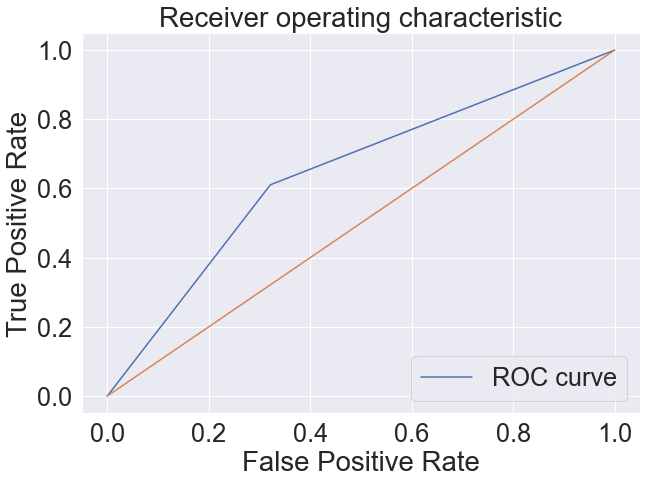

In [293]:
# plot della curca ROC

plot_roc(y_test, pred)

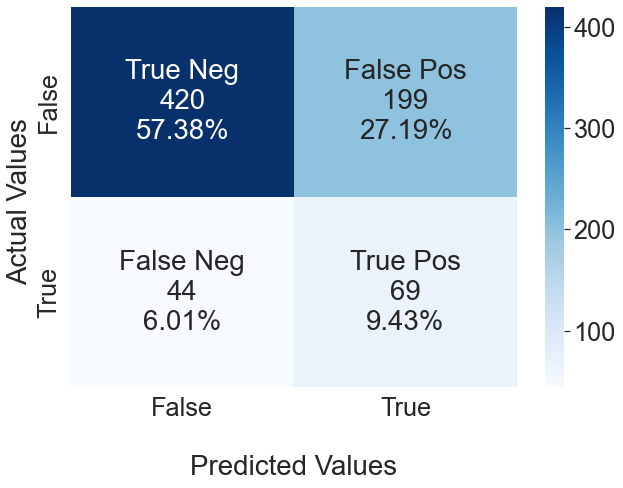

In [294]:
# matrice di confusione

plot_confusion_matrix(y_test, pred)

# analizzando la matrice di confusione si notano 50 falsi negativi e 234 falsi positivi. Dal momento in cui, per le considerazioni fatte precedentemente, il numero di falsi negativi non è esageratamente alto i risultati ottenuti sono soddisfacenti.

In [295]:
# viene utilizzato shap per vedere come è possibile dare una spiegazione su come opera il modello

shap_values = shap.TreeExplainer(mod).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>